### import toolkit

In [95]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import open3d as o3d

In [96]:
DATASET_DIR = "Assignment 1 Input Images/Question 2 and 3 Images"
LEFT_IMAGE_RELATIVE_PATH = "bikeL.png"
RIGHT_IMAGE_RELATIVE_PATH = "bikeR.png"
METADATA_RELATIVE_PATH = "bike.txt"

In [97]:
left_image_path = os.path.join(DATASET_DIR, LEFT_IMAGE_RELATIVE_PATH)
right_image_path = os.path.join(DATASET_DIR, RIGHT_IMAGE_RELATIVE_PATH)
metadata_path = os.path.join(DATASET_DIR, METADATA_RELATIVE_PATH)

# handle metadata

In [98]:
metadata = None
with open(metadata_path) as metadata_file:
    metadata = metadata_file.readlines()

print(metadata)

['cam0=[5299.313 0 1263.818; 0 5299.313 977.763; 0 0 1]\n', 'cam1=[5299.313 0 1438.004; 0 5299.313 977.763; 0 0 1]\n', 'baseline=177.288\n']


In [99]:
K_l = None
K_r = None
baseline = None

for i, line in enumerate(metadata):
    if i + 1 != len(metadata):
        matrix = line.split('[')[1].split(']')[0].split('; ')
        for j, row in enumerate(matrix):
            matrix[j] = [eval(x) for x in row.split(' ')]

        if i == 0:
            K_l = np.array(matrix)
        elif i == 1:
            K_r = np.array(matrix)

    else:
        baseline = eval(line.split('=')[1])

In [100]:
print(K_l)
print(K_r)
print(baseline)

[[5.299313e+03 0.000000e+00 1.263818e+03]
 [0.000000e+00 5.299313e+03 9.777630e+02]
 [0.000000e+00 0.000000e+00 1.000000e+00]]
[[5.299313e+03 0.000000e+00 1.438004e+03]
 [0.000000e+00 5.299313e+03 9.777630e+02]
 [0.000000e+00 0.000000e+00 1.000000e+00]]
177.288


In [101]:
fx = K_l[0, 0]
fy = K_l[1, 1]
ox = K_l[0, 2]
oy = K_l[1, 2]

print(fx, fy, ox, oy)

5299.313 5299.313 1263.818 977.763


In [102]:
ox2 = K_r[0, 2]
print(ox2)

1438.004


In [103]:
Q = np.array([
    [1, 0, 0, -ox],
    [0, 1, 0, -oy],
    [0, 0, 0, fx],
    [0, 0, -1/baseline, (ox-ox2)/baseline]
])
print(Q)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.26381800e+03]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -9.77763000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.29931300e+03]
 [ 0.00000000e+00  0.00000000e+00 -5.64053969e-03 -9.82503046e-01]]


# handle image

In [104]:
left_image = cv2.imread(left_image_path)
right_image = cv2.imread(right_image_path)

print(left_image.shape, right_image.shape)
print(left_image.dtype, right_image.dtype)

(2008, 2988, 3) (2008, 2988, 3)
uint8 uint8


## downsample images

In [105]:
def downsample(image, factor):
    for i in range(factor):
        row = image.shape[0]
        col = image.shape[1]

        image = cv2.pyrDown(image, dstsize=(col // 2, row // 2))
    return image

In [106]:
left_image_down = downsample(left_image, 2)
right_image_down = downsample(right_image, 2)

print(left_image_down.shape, right_image_down.shape)

(502, 747, 3) (502, 747, 3)


## compute grayscale

In [107]:
left_image_gray = cv2.cvtColor(left_image_down, cv2.COLOR_BGR2GRAY)
right_image_gray = cv2.cvtColor(right_image_down, cv2.COLOR_BGR2GRAY)

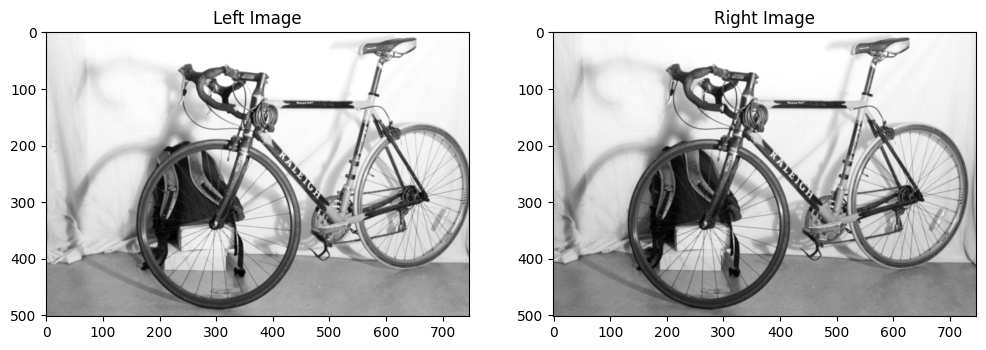

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(left_image_gray, 'gray')
ax[0].set_title("Left Image")

ax[1].imshow(right_image_gray, 'gray')
ax[1].set_title("Right Image")
plt.show()

## computing disparity map

In [109]:
MAX_DISPARITY = 16*2
PATCH_SIZE = 7

In [110]:
# # numDisparities=16*10, blocksize=53
stereo = cv2.StereoBM_create(numDisparities=MAX_DISPARITY, blockSize=PATCH_SIZE)
disparity_map = stereo.compute(left_image_gray, right_image_gray)
# disparity_map_divided = np.float32(np.divide(disparity_map, 16.0))

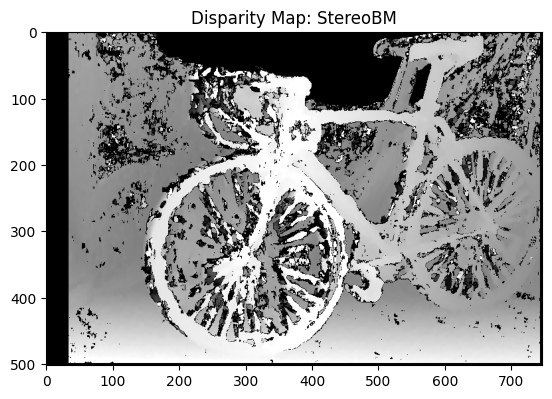

In [111]:
plt.imshow(disparity_map, 'gray')
plt.title("Disparity Map: StereoBM")
plt.show()

In [112]:
def compute_disparity_map(left_image, right_image, max_disparity, patch_size):
    assert left_image.shape == right_image.shape, f'left and right image must have same resolution for disparity map computation.'
    '''
    since patch is defined from a unique central pixel
    this implies patch size must be odd for every dimension
    also, patch is assumed to be a square
    hence, patch size are same for all dimensions
    '''
    assert patch_size & 1 == 1, f'patch size must be odd.'
    # # effective num rows > 0
    # assert patch_size <= left_image.shape[0], f'effective number of rows must be greater than 0.'
    # # effective num cols > 0
    # assert patch_size + max_disparity <= left_image.shape[1], f'effective number of columns must be greater than 0.'


    num_rows_in_image, num_cols_in_image = left_image.shape
    num_patch_neighbours = (patch_size - 1) // 2

    '''
    patch assumes current pixel as central
    since upper patch neighbours must be within image bounds
    current pixel - upper patch neighbours >= 0
    '''
    effective_num_rows_lower_bound = num_patch_neighbours
    '''
    similarly, lower patch neighbours must be within image bounds
    current pixel + lower patch neighbours < number of rows
    '''
    effective_num_rows_upper_bound = num_rows_in_image - num_patch_neighbours
    effective_num_rows = effective_num_rows_upper_bound - effective_num_rows_lower_bound
    assert effective_num_rows > 0, f'effective number of rows must be greater than 0.'

    '''
    also, algorithm searches upto max_disparity pixels to the left of current pixel
    which implies that left patch neighbours for the central pixel
    that is max disparity left to the current pixel must also be within image bounds.
    current pixel - max_disparity - left patch neighbours >= 0
    '''
    effective_num_cols_lower_bound = max_disparity + num_patch_neighbours
    '''
    since right patch neighbours must be within image bounds
    current pixel + right patch neighbours < number of cols
    '''
    effective_num_cols_upper_bound = num_cols_in_image - num_patch_neighbours
    effective_num_cols = effective_num_cols_upper_bound - effective_num_cols_lower_bound
    assert effective_num_cols > 0, f'effective number of columns must be greater than 0.'

    # total pixels for which correspondence will be found
    total_effective_pixels = effective_num_rows * effective_num_cols
    print(f"total_effective_pixels: {total_effective_pixels}")

    # ------------------------
    # CORRESPONDENCE ALGORITHM
    # ------------------------
    # pbar = tqdm(total=total_effective_pixels)
    disparity_map = np.zeros(left_image.shape)
    for i in range(effective_num_rows_lower_bound, effective_num_rows_upper_bound):
        '''
        # since row for left and right image patch is same during search
        # and every left and right image patch in current row has same row value
        # therefore, necessary right image for search is only bounded by
        # upper and lower patch neighbours
        # [current pixel - upper patch neighbours, current pixel + lower patch neighbours]
        '''
        necessary_right_image = right_image[
            i-num_patch_neighbours : i+num_patch_neighbours+1
        ]
        necessary_left_image = left_image[
            i-num_patch_neighbours : i+num_patch_neighbours+1
        ]

        for j in range(effective_num_cols_lower_bound, effective_num_cols_upper_bound):
            left_image_patch = necessary_left_image[
                :,
                j-num_patch_neighbours:j+num_patch_neighbours+1
            ]

            # ------------------------
            # BLOCK MATCHING ALGORITHM
            # ------------------------
            min_loss = np.inf
            corresponding_column = -1
            # optimization
            prev_corresponding_column = -1

            # since current pixel is right to prev. pixel
            # this is assumed true for correspoding pixels also
            # hence, search only upto previous corresponding pixel (if found)
            search_lower_bound = max(j-max_disparity, prev_corresponding_column)
            # block matching occurs from current pixel upto max disparity times left pixels
            for k in range(j, search_lower_bound-1, -1):
                right_image_patch = necessary_right_image[
                    :,
                    k-num_patch_neighbours:k+num_patch_neighbours+1
                ]

                # sum of absolute difference for pixel intensities
                loss = np.sum(np.abs(right_image_patch - left_image_patch))

                if loss < min_loss:
                    min_loss = loss
                    corresponding_column = k
            #optimization update
            prev_corresponding_column = corresponding_column
            # defining disparity as left - right instead of absolute difference
            disparity = j - corresponding_column

            disparity_map[i, j] = disparity
            print(f"pixels processed: {(i-effective_num_rows_lower_bound)*effective_num_cols + (j-effective_num_cols_lower_bound+1)}", end='\r')

    return disparity_map

In [113]:
disparity_map = compute_disparity_map(left_image_gray, right_image_gray, MAX_DISPARITY, PATCH_SIZE)

total_effective_pixels: 351664


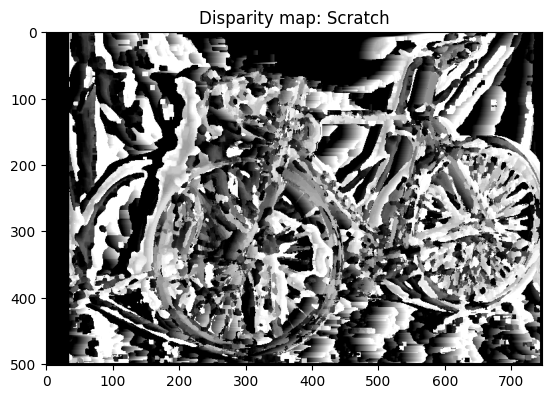

In [114]:
plt.imshow(disparity_map, 'gray')
plt.title("Disparity map: Scratch")
plt.show()

In [115]:
points = cv2.reprojectImageTo3D(np.float32(np.divide(disparity_map, 16.0)), Q)

In [116]:
colors = cv2.cvtColor(right_image_down, cv2.COLOR_BGR2RGB)

In [117]:
mask_map = disparity_map > disparity_map.min()

output_points = points[mask_map]
output_colors = colors[mask_map]

In [118]:
def create_point_cloud_file(vertices, colors, filename):
    colors = colors.reshape(-1, 3)
    vertices = np.hstack([vertices.reshape(-1, 3), colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
    '''

    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f, vertices, '%f %f %f %d %d %d')

In [119]:
output_file = 'pointcloud.ply'
create_point_cloud_file(output_points, output_colors, output_file)

In [120]:
ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud(output_file)

print(pcd)
print(np.asarray(pcd.points))

o3d.visualization.draw_geometries([pcd])

PointCloud with 271637 points.
[[ 1240.023071   983.651428 -5347.634766]
 [ 1238.573242   983.301636 -5345.733398]
 [ 1237.124634   982.952026 -5343.833008]
 ...
 [  529.091125   485.519531 -5362.897949]
 [  527.890808   485.346375 -5360.985352]
 [  526.691284   485.17334  -5359.07373 ]]
